In [1]:
#!pip install -U tensorflow --user

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import time
import missingno as msno
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model, show_versions
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, learning_curve, cross_validate
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error, median_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, Booster

In [3]:
path = "C:\Jason\Formation OCR\Projet 3\data_energy.csv"

In [4]:
df = pd.read_csv(path)
df_energy = df.copy()
df.head()

,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,...,Latitude,Longitude,NumberOfUses,BuildingAge,DistanceCentre,TotalGHGEmissions_log,SiteEnergyUse(kBtu)_log,SteamUsePercentage,ElectricityPercentage,NaturalGasPercentage
0,NonResidential,Small- and Mid-Sized Office,1.0,6.0,98370,25920,72450,Office,98370.0,45.0,...,47.606799,-122.337100,1,109,0.382750,3.855241,15.691287,0.0,99.0,1.0
1,NonResidential,Large Office,1.0,4.0,193788,37854,155934,Office,138672.0,59.0,...,47.621476,-122.343050,5,68,1.886498,4.760805,16.634519,0.0,100.0,0.0
2,NonResidential,Large Office,1.0,4.0,186971,0,186971,Office,186977.0,86.0,...,47.621243,-122.329786,2,34,1.680312,5.424598,16.354152,0.0,76.0,24.0
3,NonResidential,Medical Office,1.0,15.0,434475,250000,184475,Medical Office,434475.0,60.0,...,47.603952,-122.324062,2,7,0.650756,7.545110,17.823393,39.0,61.0,0.0
4,NonResidential,Large Office,1.0,5.0,192960,32160,160800,Office,135173.0,95.0,...,47.603730,-122.337367,2,104,0.483477,5.564290,15.713124,46.0,54.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555 entries, 0 to 1554
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1555 non-null   object 
 1   PrimaryPropertyType        1555 non-null   object 
 2   NumberofBuildings          1555 non-null   float64
 3   NumberofFloors             1555 non-null   float64
 4   PropertyGFATotal           1555 non-null   int64  
 5   PropertyGFAParking         1555 non-null   int64  
 6   PropertyGFABuilding(s)     1555 non-null   int64  
 7   LargestPropertyUseType     1555 non-null   object 
 8   LargestPropertyUseTypeGFA  1555 non-null   float64
 9   ENERGYSTARScore            1002 non-null   float64
 10  SiteEnergyUse(kBtu)        1555 non-null   float64
 11  SteamUse(kBtu)             1555 non-null   float64
 12  Electricity(kBtu)          1555 non-null   float64
 13  NaturalGas(kBtu)           1555 non-null   float

### Les hypothèses
- Une relation linéaire existe entre la variable indépendante (X) et la variable dépendante (y)
- Peu ou pas d'autocorrélation entre les résidus

In [6]:
def prepare_data(data, y_target):
    
    
    num_col = list(data.dtypes[data.dtypes != np.object].index)
    
    X = data.drop(y_target, axis=1)
    y = data[y_target]

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test

def process_data(X, y, data, scaler, encoder):
    
    object_col = list(data.dtypes[data.dtypes == np.object].index)
    num_col = [col for col in list(data.dtypes[data.dtypes != np.object].index) if col not in y.columns.tolist()]
    
    preprocessor = make_column_transformer((scaler, num_col),(encoder, object_col))
    
    return preprocessor

In [7]:
# Coefficient de détermination r2
# Évalue la performance du modèle par rapport au niveau de variation présent dans les donnnées


#####################################################################################
# ÉVALUATION du modèle
#####################################################################################

def eval_model(lin_algo, xtrain, ytrain, xtest, ytest, processor, plot=False):
    
    model = make_pipeline(processor, lin_algo)
    model.fit(xtrain, ytrain)
    prediction = model.predict(xtest)
    
    # R2 score
    #cv = StratifiedKFold(4)
    #cv = 3
    #train_score = cross_val_score(model, xtrain, ytrain, cv=cv)
    #train_score = np.round(train_score, 4)*100
    pred_score = model.score(xtest, ytest)
    pred_score = np.round(pred_score, 4)*100
    
    
    length = 20000
    a,b = np.polyfit(ytest, prediction,1)
    
    #rmse calcul
    rmse = np.round(np.sqrt(mean_squared_error(ytest,prediction)), 2)
    mean_abs_err = np.round(mean_absolute_error(ytest,prediction), 2)
    med_abs_err = np.round(median_absolute_error(ytest,prediction), 2)

    
    if plot == True:

        print("score test r2 :", pred_score,"%")
        print("RMSE:", rmse)
        print("mean_abs_err:", mean_abs_err)
        print("med_abs_err:", med_abs_err)
        plt.figure(figsize=(5, 5))
        plt.plot(ytest,(a*ytest+b),label='linear regression')
        plt.plot(ytest[:length], prediction[:length],'ro', markersize=1)
        plt.xlabel("Valeur prédite")
        plt.ylabel("Valeur réelle")
        plt.show()
        
    return pred_score, rmse, mean_abs_err, med_abs_err, prediction


def model_result(target_var, model, X_train, y_train, X_test, y_test, preprocessor, plot):
    
    results = {}
    prediction = {}
    
    for var in target_var:

        for name, algo in model.items():
            key = name + "_" + var
            
            if plot == True:
                print("\n")
                print("#####################################################################################")
                print(f"                                    {name}, {var}                               ")
                print("\n")

            t0 = time.time()
            r2, rmse, mean_abs_err, med_abs_err, y_pred = eval_model(algo, X_train, y_train[var], X_test, y_test[var], preprocessor, plot)
            t1 = time.time()

            results[f"{key}"] = {}
            results[f"{key}"]["Algorithme"] = name
            results[f"{key}"]["Target"] = var
            results[f"{key}"]["Opti_time"] = round((t1 - t0), 2)
            results[f"{key}"]["R2"] = r2
            results[f"{key}"]["RMSE"] = rmse
            results[f"{key}"]["mean_abs_err"] = mean_abs_err
            results[f"{key}"]["med_abs_err"] = med_abs_err
            
            prediction[f"{key}"] = y_pred

    
    df_results = pd.DataFrame.from_dict(results).transpose()
    prediction = pd.DataFrame.from_dict(prediction)
            
    return df_results, prediction
        

    


### Prédiction ENERGYSTARScore

In [8]:
df_energy_clean = df_energy.dropna()

In [9]:
df_energy_clean = df_energy.dropna()
to_drop = [
   "LargestPropertyUseType",
 'TotalGHGEmissions_log',
 'SiteEnergyUse(kBtu)_log',
 'SteamUsePercentage',
 'ElectricityPercentage',
 'NaturalGasPercentage']


df_energy_clean = df_energy_clean.drop(to_drop, axis=1)
display(df_energy_clean.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002 entries, 0 to 1540
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1002 non-null   object 
 1   PrimaryPropertyType        1002 non-null   object 
 2   NumberofBuildings          1002 non-null   float64
 3   NumberofFloors             1002 non-null   float64
 4   PropertyGFATotal           1002 non-null   int64  
 5   PropertyGFAParking         1002 non-null   int64  
 6   PropertyGFABuilding(s)     1002 non-null   int64  
 7   LargestPropertyUseTypeGFA  1002 non-null   float64
 8   ENERGYSTARScore            1002 non-null   float64
 9   SiteEnergyUse(kBtu)        1002 non-null   float64
 10  SteamUse(kBtu)             1002 non-null   float64
 11  Electricity(kBtu)          1002 non-null   float64
 12  NaturalGas(kBtu)           1002 non-null   float64
 13  TotalGHGEmissions          1002 non-null   float

None

In [10]:
y_Energy = ["ENERGYSTARScore"]

X_train_clean, X_test_clean, y_train_clean, y_test_clean = prepare_data(df_energy_clean, y_Energy)
preprocessor_clean = process_data(X_train_clean, y_train_clean,  df_energy_clean, RobustScaler(), OneHotEncoder(handle_unknown='ignore'))

y_train_clean["ENERGYSTARScore"].ravel()

model = {"LinearRegression" : linear_model.LinearRegression(),
        "Ridge" : linear_model.Ridge(),
        "Lasso" : linear_model.Lasso(tol=0.8),
        "SVR" : svm.SVR(),
        "KNeighborsRegressor" : KNeighborsRegressor(),
        "RandomForestRegressor" : RandomForestRegressor(),
        "AdaBoostRegressor": AdaBoostRegressor(),
        "GradientBoostingRegressor": GradientBoostingRegressor(),
        "XGBRegressor" : XGBRegressor()}

df_results_ESS, prediction = model_result(y_Energy, model, X_train_clean, y_train_clean, X_test_clean, y_test_clean, preprocessor_clean, False)


In [11]:
display(df_results_ESS.sort_values("RMSE"))


,Algorithme,Target,Opti_time,R2,RMSE,mean_abs_err,med_abs_err
GradientBoostingRegressor_ENERGYSTARScore,GradientBoostingRegressor,ENERGYSTARScore,0.32,38.19,22.38,17.08,13.83
XGBRegressor_ENERGYSTARScore,XGBRegressor,ENERGYSTARScore,0.49,33.94,23.14,17.18,12.91
RandomForestRegressor_ENERGYSTARScore,RandomForestRegressor,ENERGYSTARScore,0.69,32.26,23.43,17.57,13.12
AdaBoostRegressor_ENERGYSTARScore,AdaBoostRegressor,ENERGYSTARScore,0.16,15.61,26.16,22.4,21.88
Lasso_ENERGYSTARScore,Lasso,ENERGYSTARScore,0.03,1.26,28.29,22.62,20.29
KNeighborsRegressor_ENERGYSTARScore,KNeighborsRegressor,ENERGYSTARScore,0.04,-2.26,28.79,22.28,17.6
SVR_ENERGYSTARScore,SVR,ENERGYSTARScore,0.19,-9.42,29.78,23.21,17.9
Ridge_ENERGYSTARScore,Ridge,ENERGYSTARScore,0.03,-16.53,30.73,21.58,17.27
LinearRegression_ENERGYSTARScore,LinearRegression,ENERGYSTARScore,0.06,-19.81,31.16,21.75,17.7


In [116]:
mean_ESS = df_energy_clean["ENERGYSTARScore"].mean()
med_ESS = df_energy_clean["ENERGYSTARScore"].median()

ESS_mean = [mean_ESS] * len(y_test_clean)
ESS_med = [med_ESS] * len(y_test_clean)

df_pred_ESS = pd.DataFrame(y_test_clean).reset_index()
df_pred_ESS["ESS_mean"] = ESS_mean
df_pred_ESS["ESS_med"] = ESS_med
df_pred_ESS["ESS_GBR_model"] = prediction["GradientBoostingRegressor_ENERGYSTARScore"]

#mean_abs_err = np.round(mean_absolute_error(ytest,prediction), 2)
#med_abs_err = np.round(median_absolute_error(ytest,prediction), 2)

df_pred_ESS["ESS_mean_abs_error"] = (df_pred_ESS["ENERGYSTARScore"] - df_pred_ESS["ESS_mean"]).abs()
df_pred_ESS["ESS_med_abs_error"] = (df_pred_ESS["ENERGYSTARScore"] - df_pred_ESS["ESS_med"]).abs()
df_pred_ESS["ESS_GBR_model_error"] = (df_pred_ESS["ENERGYSTARScore"] - df_pred_ESS["ESS_GBR_model"]).abs()

display(df_pred_ESS.head().round(2))
display(df_pred_ESS.describe(percentiles=[0.90]).round(2))



,index,ENERGYSTARScore,ESS_mean,ESS_med,ESS_GBR_model,ESS_mean_abs_error,ESS_med_abs_error,ESS_GBR_model_error
0,1009,100.0,63.71,71.0,87.54,36.29,29.0,12.46
1,1105,1.0,63.71,71.0,21.81,62.71,70.0,20.81
2,984,88.0,63.71,71.0,39.37,24.29,17.0,48.63
3,1059,69.0,63.71,71.0,70.19,5.29,2.0,1.19
4,263,72.0,63.71,71.0,71.15,8.29,1.0,0.85


,index,ENERGYSTARScore,ESS_mean,ESS_med,ESS_GBR_model,ESS_mean_abs_error,ESS_med_abs_error,ESS_GBR_model_error
count,201.00,201.00,201.00,201.0,201.00,201.00,201.00,201.00
mean,693.41,62.18,63.71,71.0,64.49,23.59,23.26,17.08
std,439.25,28.54,0.00,0.0,17.18,16.05,18.69,14.51
min,10.00,1.00,63.71,71.0,-1.80,0.71,0.00,0.05
50%,654.00,69.00,63.71,71.0,67.54,23.29,18.00,13.83
90%,1362.00,95.00,63.71,71.0,86.16,48.71,56.00,37.25
max,1535.00,100.00,63.71,71.0,94.62,62.71,70.00,97.80


Au vue des résultats de prédiction, il semble qu'une prédiction selon le modele GradientBoostingRegressor semble plus précis que d'imputer par la médiane ou par la  moyenne.

In [13]:
# imputation des valeurs manquantes par prédiction de la variable ENERGYSTARScore

df = pd.read_csv(path)

model = make_pipeline(preprocessor_clean, GradientBoostingRegressor())
model.fit(X_train_clean, y_train_clean)
score = cross_val_score(model, X_train_clean, y_train_clean, cv=5)
print("score:", score)

print("X_train_clean.shape:", "\n", X_train_clean.shape)



score: [0.36974842 0.37666516 0.39344047 0.42186539 0.39577961]
X_train_clean.shape: 
 (801, 18)


In [14]:
df["ENERGYSTARScore_pred"] = model.predict(df[X_train_clean.columns.tolist()])

In [15]:
# apercu prediction sur les valeurs connues 
display(df[~df["ENERGYSTARScore"].isnull()][["ENERGYSTARScore", "ENERGYSTARScore_pred"]])
display(df[df["ENERGYSTARScore"].isnull()][["ENERGYSTARScore", "ENERGYSTARScore_pred"]])
df["ENERGYSTARScore"].fillna(df["ENERGYSTARScore_pred"], inplace=True) 
display(df[["ENERGYSTARScore", "ENERGYSTARScore_pred"]])

df = df.drop("ENERGYSTARScore_pred", axis=1)

,ENERGYSTARScore,ENERGYSTARScore_pred
0,45.0,57.640932
1,59.0,61.288980
2,86.0,79.042305
3,60.0,52.921865
4,95.0,88.960235
...,...,...
1535,98.0,88.757010
1536,72.0,75.934039
1537,37.0,45.381531
1538,9.0,24.615782


,ENERGYSTARScore,ENERGYSTARScore_pred
7,NaN,9.532020
8,NaN,94.428917
12,NaN,48.300660
13,NaN,96.328130
14,NaN,25.579311
...,...,...
1550,NaN,48.639738
1551,NaN,47.389833
1552,NaN,27.377993
1553,NaN,70.930345


,ENERGYSTARScore,ENERGYSTARScore_pred
0,45.000000,57.640932
1,59.000000,61.288980
2,86.000000,79.042305
3,60.000000,52.921865
4,95.000000,88.960235
...,...,...
1550,48.639738,48.639738
1551,47.389833,47.389833
1552,27.377993,27.377993
1553,70.930345,70.930345


<AxesSubplot:>

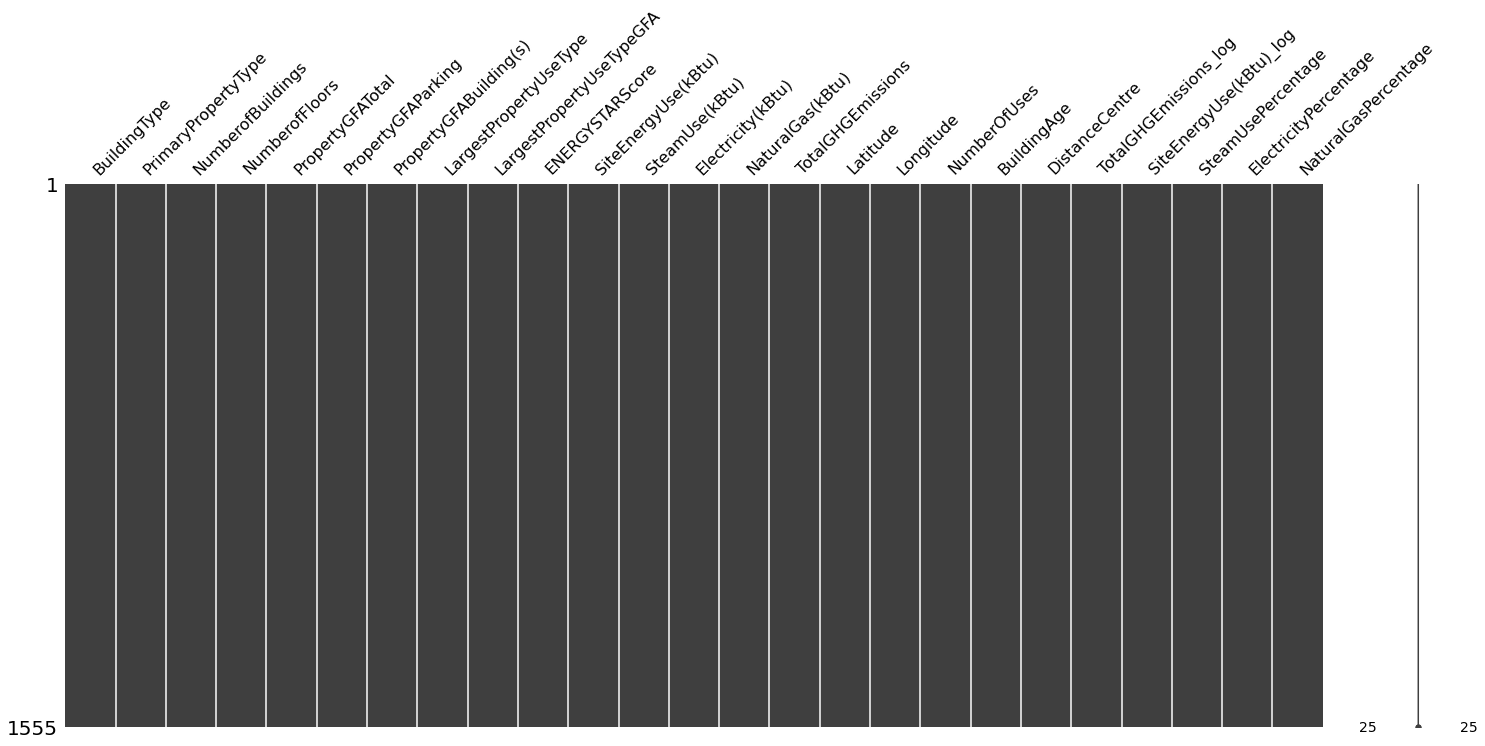

In [16]:
msno.matrix(df)

In [17]:
# Dictionnaire de modèle à tester
model = {"LinearRegression" : linear_model.LinearRegression(),
        "Ridge" : linear_model.Ridge(),
        "Lasso" : linear_model.Lasso(tol=0.8),
        "SVR" : svm.SVR(),
        "KNeighborsRegressor" : KNeighborsRegressor(),
        "RandomForestRegressor" : RandomForestRegressor(),
        "AdaBoostRegressor": AdaBoostRegressor(),
        "GradientBoostingRegressor": GradientBoostingRegressor(),
        "XGBRegressor" : XGBRegressor()}

# variable à prédire
var_pred = ["TotalGHGEmissions", "TotalGHGEmissions_log", "SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log"]

#df["LargestPropertyUseType"].value_counts()
#df["PropertyGFABuilding(s)"].value_counts()
df.head()


,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,...,Latitude,Longitude,NumberOfUses,BuildingAge,DistanceCentre,TotalGHGEmissions_log,SiteEnergyUse(kBtu)_log,SteamUsePercentage,ElectricityPercentage,NaturalGasPercentage
0,NonResidential,Small- and Mid-Sized Office,1.0,6.0,98370,25920,72450,Office,98370.0,45.0,...,47.606799,-122.337100,1,109,0.382750,3.855241,15.691287,0.0,99.0,1.0
1,NonResidential,Large Office,1.0,4.0,193788,37854,155934,Office,138672.0,59.0,...,47.621476,-122.343050,5,68,1.886498,4.760805,16.634519,0.0,100.0,0.0
2,NonResidential,Large Office,1.0,4.0,186971,0,186971,Office,186977.0,86.0,...,47.621243,-122.329786,2,34,1.680312,5.424598,16.354152,0.0,76.0,24.0
3,NonResidential,Medical Office,1.0,15.0,434475,250000,184475,Medical Office,434475.0,60.0,...,47.603952,-122.324062,2,7,0.650756,7.545110,17.823393,39.0,61.0,0.0
4,NonResidential,Large Office,1.0,5.0,192960,32160,160800,Office,135173.0,95.0,...,47.603730,-122.337367,2,104,0.483477,5.564290,15.713124,46.0,54.0,0.0


# Préparation du data pour prédiction avec ENERGYSTARScore

In [18]:
df_ESS = df.copy()

# Colonne à supprimer: 
    # PropertyGFATotal : Redondance : PropertyGFATotal = PropertyGFABuilding(s) + PropertyGFAParking
    # LargestPropertyUseType : Redondance avec PrimaryPropertyType
to_drop = ["PropertyGFATotal", "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)", "LargestPropertyUseType",]

df_ESS = df_ESS.drop(to_drop, axis=1)
y_target = ["TotalGHGEmissions", "TotalGHGEmissions_log", "SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log"]

X_train, X_test, y_train, y_test = prepare_data(df_ESS, y_target)
preprocessor = process_data(X_train, y_train,  df_ESS, RobustScaler(), OneHotEncoder(handle_unknown='ignore'))

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (1244, 16)
X_test: (311, 16)
y_train: (1244, 4)
y_test: (311, 4)


## Prédiction AVEC ENERGYSTARScore

In [19]:
# RobustScaler et OnehotEncoder

display(X_train.head())
df_results_ESS, prediction_ESS = model_result(var_pred, model, X_train, y_train, X_test, y_test, preprocessor, False)



,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,Latitude,Longitude,NumberOfUses,BuildingAge,DistanceCentre,SteamUsePercentage,ElectricityPercentage,NaturalGasPercentage
1281,NonResidential,Worship Facility,1.0,1.0,0,48850,28725.0,91.598158,47.60514,-122.32613,3,116,0.460947,77.0,23.0,1.0
395,NonResidential,Other,1.0,1.0,41600,11440,51427.0,45.649692,47.55787,-122.33500,1,16,5.379653,0.0,54.0,46.0
80,Nonresidential COS,Other,1.0,1.0,0,91213,65000.0,58.065106,47.62208,-122.35398,1,54,2.410671,51.0,46.0,0.0
1441,NonResidential,Small- and Mid-Sized Office,1.0,3.0,9616,19232,19232.0,82.000000,47.63441,-122.28061,2,34,4.970758,0.0,100.0,0.0
994,NonResidential,Warehouse,1.0,2.0,0,25840,25840.0,92.000000,47.59783,-122.31554,1,60,1.550573,0.0,100.0,0.0


In [20]:
#Résultat prédiction avec ENERGYSTARScore
df_GHG_ESS = df_results_ESS[df_results_ESS["Target"].str.contains("Total")].reset_index().drop("index", axis=1).sort_values(by=['RMSE'])

df_EnerUse_ESS = df_results_ESS[~df_results_ESS["Target"].str.contains("Total")].reset_index().drop("index", axis=1).sort_values(by=['RMSE'])

print("Résultat des prédiction avec ENERGYSTARScore pour chaque algorithme utilisé sur les données de test")

display(df_GHG_ESS)
display(df_EnerUse_ESS)

Résultat des prédiction avec ENERGYSTARScore pour chaque algorithme utilisé sur les données de test


,Algorithme,Target,Opti_time,R2,RMSE,mean_abs_err,med_abs_err
16,GradientBoostingRegressor,TotalGHGEmissions_log,0.37,88.06,0.55,0.41,0.32
17,XGBRegressor,TotalGHGEmissions_log,0.34,87.85,0.56,0.42,0.33
14,RandomForestRegressor,TotalGHGEmissions_log,1.02,82.96,0.66,0.48,0.35
15,AdaBoostRegressor,TotalGHGEmissions_log,0.21,78.31,0.75,0.57,0.46
10,Ridge,TotalGHGEmissions_log,0.04,73.59,0.82,0.6,0.48
9,LinearRegression,TotalGHGEmissions_log,0.04,73.26,0.83,0.61,0.48
13,KNeighborsRegressor,TotalGHGEmissions_log,0.04,62.4,0.98,0.75,0.61
11,Lasso,TotalGHGEmissions_log,0.03,20.33,1.43,1.12,0.91
12,SVR,TotalGHGEmissions_log,0.31,6.58,1.55,1.2,0.96
8,XGBRegressor,TotalGHGEmissions,0.33,76.19,465.59,105.2,19.65


,Algorithme,Target,Opti_time,R2,RMSE,mean_abs_err,med_abs_err
17,XGBRegressor,SiteEnergyUse(kBtu)_log,0.29,86.36,0.5,0.37,0.26
16,GradientBoostingRegressor,SiteEnergyUse(kBtu)_log,0.36,86.45,0.5,0.36,0.27
14,RandomForestRegressor,SiteEnergyUse(kBtu)_log,1.01,83.24,0.56,0.39,0.27
15,AdaBoostRegressor,SiteEnergyUse(kBtu)_log,0.24,76.04,0.67,0.51,0.39
13,KNeighborsRegressor,SiteEnergyUse(kBtu)_log,0.05,66.49,0.79,0.6,0.47
10,Ridge,SiteEnergyUse(kBtu)_log,0.03,66.46,0.79,0.58,0.46
9,LinearRegression,SiteEnergyUse(kBtu)_log,0.04,65.55,0.8,0.58,0.46
11,Lasso,SiteEnergyUse(kBtu)_log,0.04,23.76,1.19,0.93,0.79
12,SVR,SiteEnergyUse(kBtu)_log,0.29,14.31,1.26,0.95,0.75
0,LinearRegression,SiteEnergyUse(kBtu),0.04,59.59,18654131.85,5595004.05,2560544.82


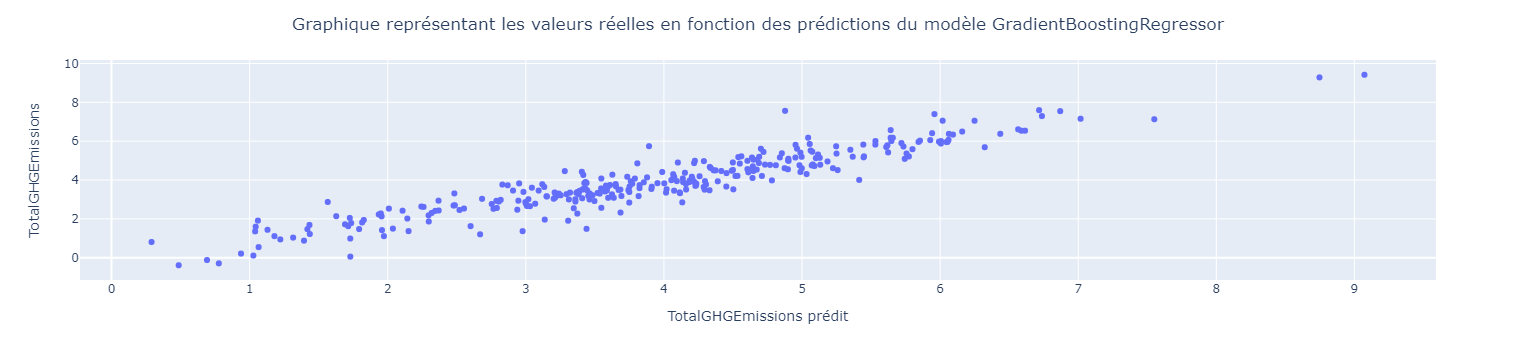

In [103]:
fig = px.scatter(x=prediction_ESS["GradientBoostingRegressor_TotalGHGEmissions_log"], y=y_test["TotalGHGEmissions_log"])
fig.update_layout(title={
        'text': "Graphique représentant les valeurs réelles en fonction des prédictions du modèle GradientBoostingRegressor",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="TotalGHGEmissions prédit",
    yaxis_title="TotalGHGEmissions",)
fig.show()

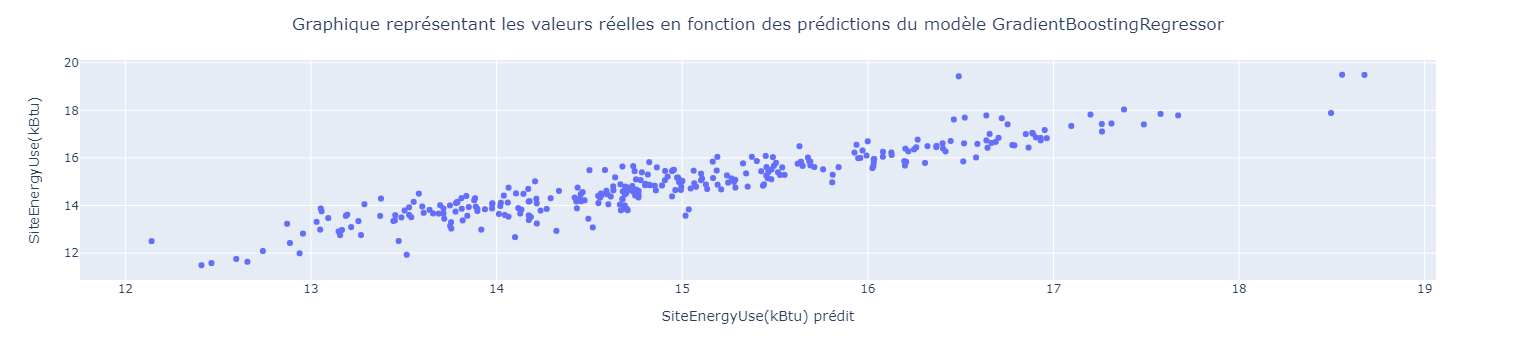

In [104]:
fig = px.scatter(x=prediction_ESS["GradientBoostingRegressor_SiteEnergyUse(kBtu)_log"], y=y_test["SiteEnergyUse(kBtu)_log"])
fig.update_layout(title={
        'text': "Graphique représentant les valeurs réelles en fonction des prédictions du modèle GradientBoostingRegressor",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="SiteEnergyUse(kBtu) prédit",
    yaxis_title="SiteEnergyUse(kBtu)",)
fig.show()

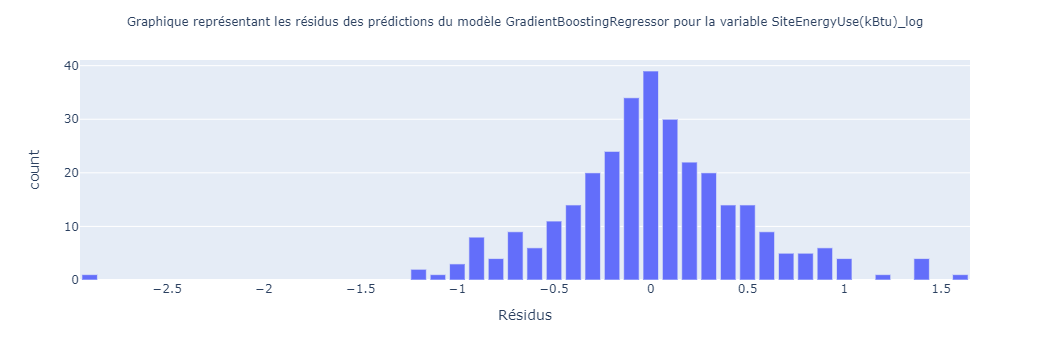

-254174894.0 39895670.0


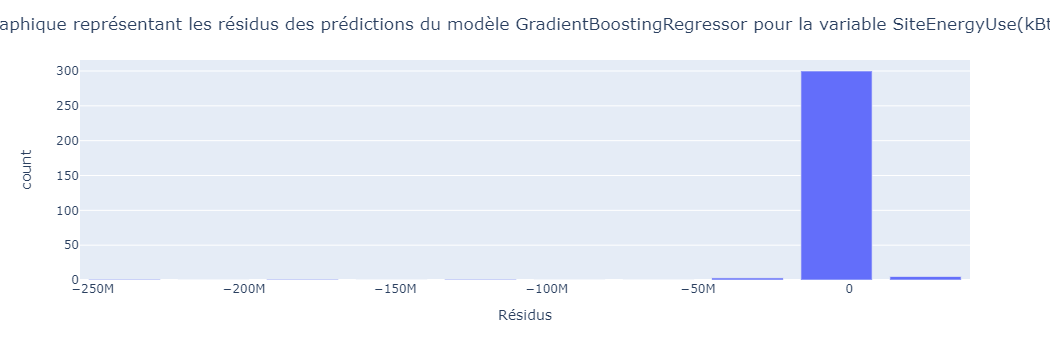

In [118]:
# Distribution des erreurs:

y_test_erreur = y_test["SiteEnergyUse(kBtu)_log"].reset_index().drop("index", axis=1)
erreur = round(np.subtract(prediction_ESS["GradientBoostingRegressor_SiteEnergyUse(kBtu)_log"], y_test_erreur["SiteEnergyUse(kBtu)_log"]), 1)

fig = px.bar(x=erreur.value_counts().index.tolist(), y=erreur.value_counts().tolist(), orientation='v')
fig.update_layout(title={
        'text': "Graphique représentant les résidus des prédictions du modèle GradientBoostingRegressor pour la variable SiteEnergyUse(kBtu)_log",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        xaxis_title="Résidus",
        yaxis_title="count",
        title_font_size=12)
fig.show()

y_test_erreur = y_test["SiteEnergyUse(kBtu)"].reset_index().drop("index", axis=1)
erreur = round(np.subtract(prediction_ESS["GradientBoostingRegressor_SiteEnergyUse(kBtu)"], y_test_erreur["SiteEnergyUse(kBtu)"]), 0)
print(min(erreur), max(erreur))
# create the bins
counts, bins = np.histogram(erreur)
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'Résidus', 'y':'count'})
fig.update_layout(title={
        'text': "Graphique représentant les résidus des prédictions du modèle GradientBoostingRegressor pour la variable SiteEnergyUse(kBtu)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',},)
fig.show()

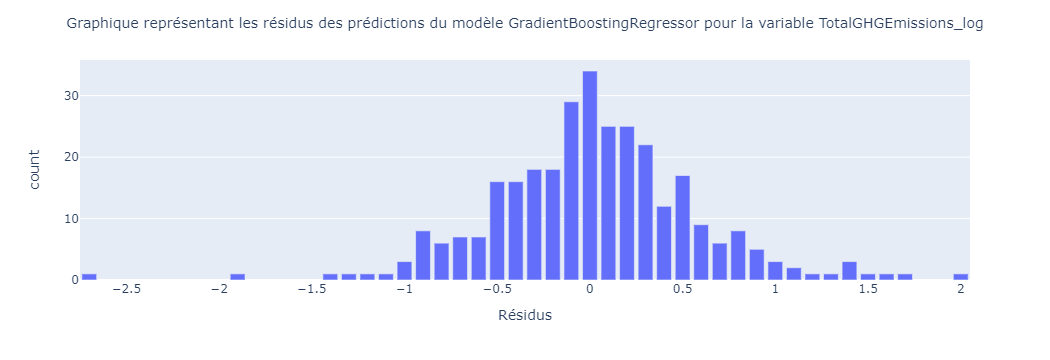

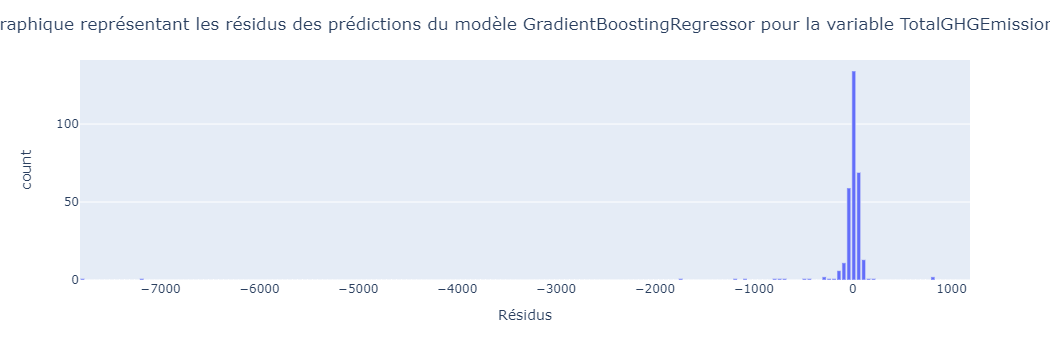

In [122]:
# Distribution des erreurs:

y_test_erreur = y_test["TotalGHGEmissions_log"].reset_index().drop("index", axis=1)
erreur = round(np.subtract(prediction_ESS["GradientBoostingRegressor_TotalGHGEmissions_log"], y_test_erreur["TotalGHGEmissions_log"]), 1)

fig = px.bar(x=erreur.value_counts().index.tolist(), y=erreur.value_counts().tolist(), orientation='v')
fig.update_layout(title={
        'text': "Graphique représentant les résidus des prédictions du modèle GradientBoostingRegressor pour la variable TotalGHGEmissions_log",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font_size': 14},
        xaxis_title="Résidus",
        yaxis_title="count")
fig.show()

y_test_erreur = y_test["TotalGHGEmissions"].reset_index().drop("index", axis=1)
erreur = round(np.subtract(prediction_ESS["GradientBoostingRegressor_TotalGHGEmissions"], y_test_erreur["TotalGHGEmissions"]), 0)
# create the bins
counts, bins = np.histogram(erreur, bins=range(int(min(erreur)), int(max(erreur)), 50))
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'Résidus', 'y':'count'})
fig.update_layout(title={
        'text': "Graphique représentant les résidus des prédictions du modèle GradientBoostingRegressor pour la variable TotalGHGEmissions",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},)
fig.show()

- On semble globalement avoir des meilleurs résultats le RobustScaler qu'avec le StandardScaler
- De plus  GradientBoostingRegressor est le meilleur modèle pour notre dataset au vue des résulats
- Meilleurs résultats avec les target mises au log (Distribution normale des résidus)

# Features important

,features_names,features_importances
28,PrimaryPropertyType_Refrigerated Warehouse,0.000000
26,PrimaryPropertyType_Non-Refrigerated Warehouse,0.000000
24,PrimaryPropertyType_Medical Office,0.000000
23,PrimaryPropertyType_Large Office,0.000000
20,PrimaryPropertyType_Hotel,0.000000
17,BuildingType_SPS-District K-12,0.000000
14,BuildingType_Campus,0.000000
29,PrimaryPropertyType_Residence Hall,0.000050
16,BuildingType_Nonresidential COS,0.000083
11,SteamUsePercentage,0.000083


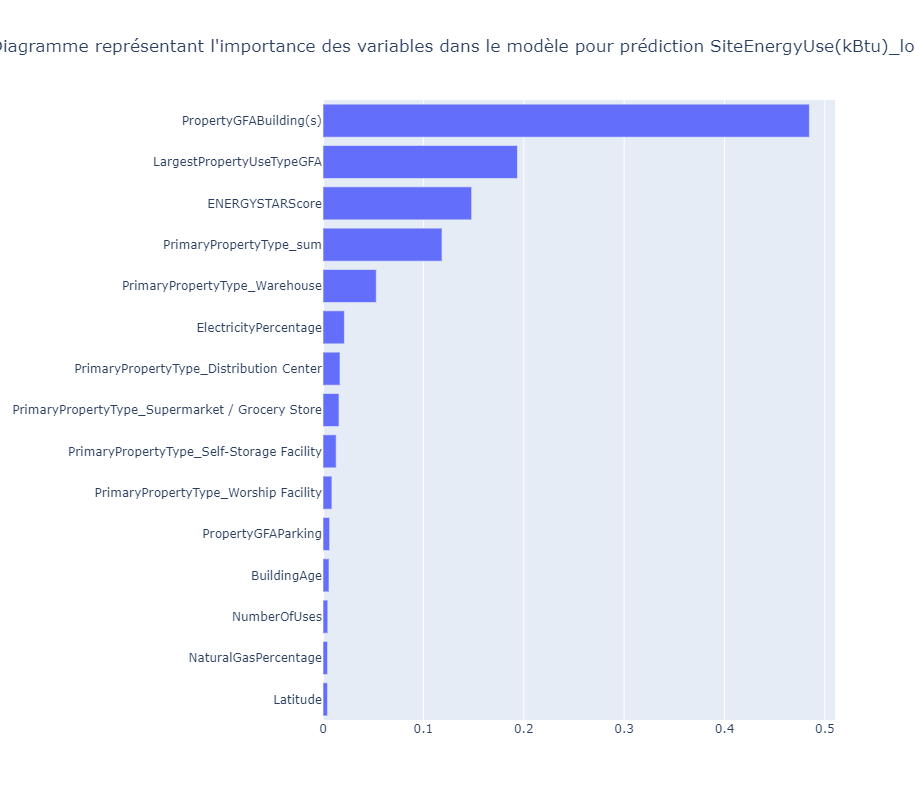

In [138]:
# Features important SiteEnergyUse(kBtu)_log
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
import plotly.express as px



target = "SiteEnergyUse(kBtu)_log"

model = make_pipeline(preprocessor, GradientBoostingRegressor())
model.fit(X_train, y_train[target])

col_transformer =  model.named_steps['columntransformer']

rs_col = col_transformer.named_transformers_["robustscaler"].feature_names_in_
ohe_col = col_transformer.named_transformers_["onehotencoder"].get_feature_names_out()

features_names = np.append(rs_col, ohe_col)

features_importances = model.named_steps['gradientboostingregressor'].feature_importances_

model_feat = pd.DataFrame()
model_feat["features_names"] = features_names
model_feat["features_importances"] = features_importances


total_property = sum([x for x in model_feat["features_importances"][model_feat["features_names"].str.contains("Primary")]])
model_feat.loc[len(model_feat.index)] = ["PrimaryPropertyType_sum", total_property]

model_feat = model_feat.sort_values("features_importances", ascending=True)
display(model_feat)
# Répartition des type de batiments

#fig = px.bar(model_feat, x='features_importances', y='features_names')
fig = go.Figure(go.Bar(
            x=model_feat["features_importances"].tail(15),
            y=model_feat["features_names"].tail(15),
            orientation='h'))
fig.update_layout(
    autosize=False, width=1000, height=800,)
fig.update_layout(title={
        'text': f"Diagramme représentant l'importance des variables dans le modèle pour prédiction {target}",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})



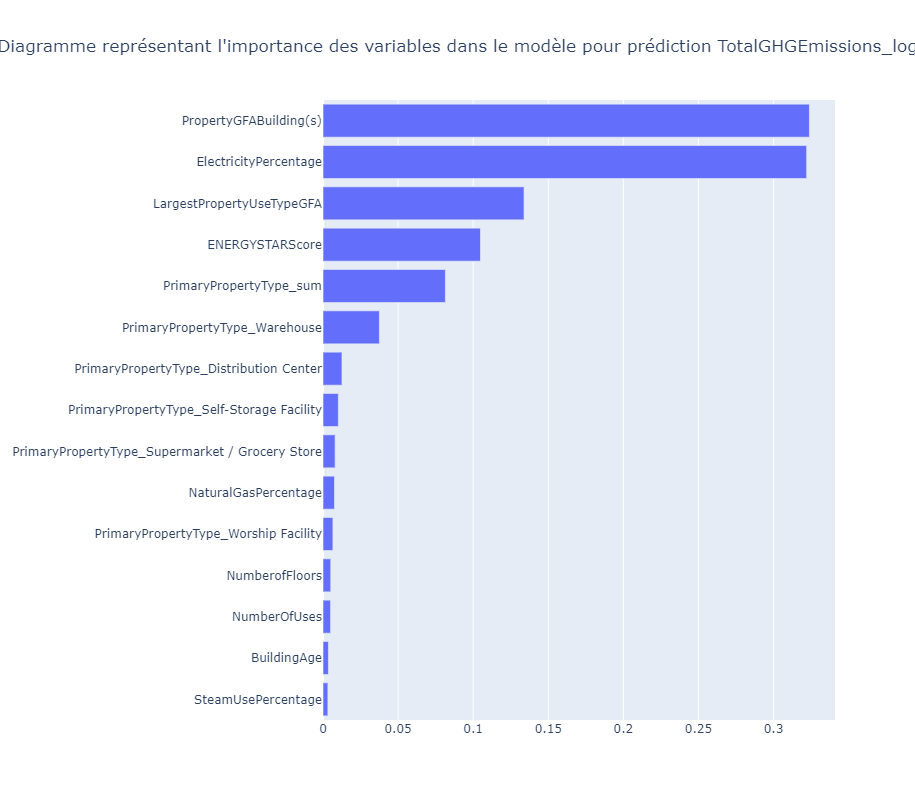

In [139]:
# Features important TotalGHGEmissions_log
from sklearn.feature_selection import SelectFromModel, RFE, RFECV


target = "TotalGHGEmissions_log"

model = make_pipeline(preprocessor, GradientBoostingRegressor())
model.fit(X_train, y_train[target])

col_transformer =  model.named_steps['columntransformer']

rs_col = col_transformer.named_transformers_["robustscaler"].feature_names_in_
ohe_col = col_transformer.named_transformers_["onehotencoder"].get_feature_names_out()

features_names = np.append(rs_col, ohe_col)

features_importances = model.named_steps['gradientboostingregressor'].feature_importances_

model_feat = pd.DataFrame()
model_feat["features_names"] = features_names
model_feat["features_importances"] = features_importances

total_property = sum([x for x in model_feat["features_importances"][model_feat["features_names"].str.contains("Primary")]])
model_feat.loc[len(model_feat.index)] = ["PrimaryPropertyType_sum", total_property]

model_feat = model_feat.sort_values("features_importances", ascending=True)

# Répartition des type de batiments
fig = go.Figure(go.Bar(
            x=model_feat["features_importances"].tail(15),
            y=model_feat["features_names"].tail(15),
            orientation='h'))
fig.update_layout(
    autosize=False, width=1000, height=800,)
fig.update_layout(title={
        'text': f"Diagramme représentant l'importance des variables dans le modèle pour prédiction {target}",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

# Best Params

In [28]:
# Recherche des meilleurs params pour le GradientBoostingRegressor avec ENERGYSTARScore
# On va tenter d'améliorer les performances de notre modèles avec gridsearchcv
from sklearn.pipeline import Pipeline
GBR = {'gradientboostingregressor__learning_rate' : [0.1, 0.01, 0.05, 0.001],
             'gradientboostingregressor__n_estimators' : [10, 25, 50, 75,100]}
model = make_pipeline(preprocessor, GradientBoostingRegressor(),)
grid = GridSearchCV(model, param_grid=GBR, cv=5)
grid.fit(X_train, y_train["TotalGHGEmissions_log"])

print('Best params:', grid.best_params_)
print('Best score:', grid.best_score_)


Best params: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__n_estimators': 100}
Best score: 0.8829505405155906


In [141]:
def plot_learning_curve(estimator, name, title, X, y, ylim=None, cv=None,
                    n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    #if ylim is not None:
        #plt.ylim(*ylim)
    plt.ylim(0.5, 1.01)
    plt.yticks([0.5 , 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0])
    #plt.yticks(round(np.linspace(0.5, 1, 10), 1))
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    #print(test_scores)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc='lower right')
    plt.savefig(name)
    return plt



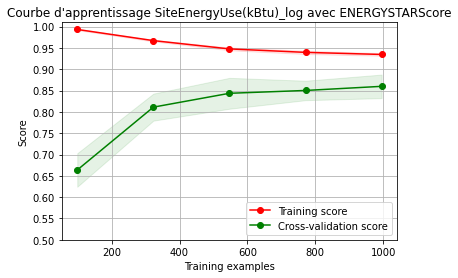

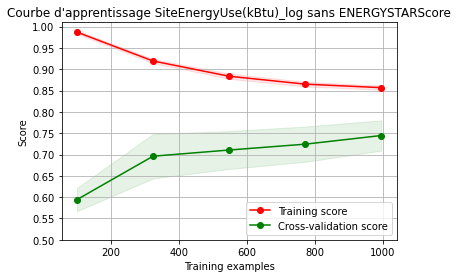

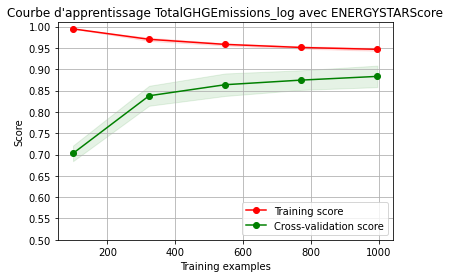

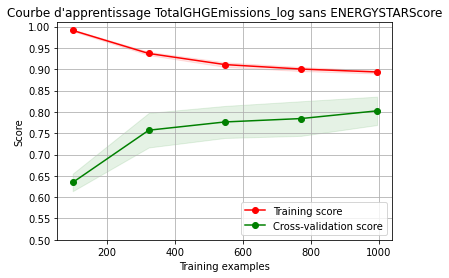

In [142]:
# Préparation du data sans ENERGYSTARScore
X_train_sans_ESS, X_test_sans_ESS = X_train.drop("ENERGYSTARScore", axis=1), X_test.drop("ENERGYSTARScore", axis=1)
df_sans_ESS = df_ESS.drop("ENERGYSTARScore", axis=1)
preprocessor_sans_ESS = process_data(X_train_sans_ESS, y_train, df_sans_ESS, RobustScaler(), OneHotEncoder(handle_unknown='ignore'))


model_ESS = make_pipeline(preprocessor, GradientBoostingRegressor())

model_sans_ESS = make_pipeline(preprocessor_sans_ESS, GradientBoostingRegressor())

# Learning curves Émission de Gaz à effet de serre avec Energy star Score
target = "SiteEnergyUse(kBtu)_log"
titre = f"Courbe d'apprentissage {target} avec ENERGYSTARScore"
plt_cons_ESS = plot_learning_curve(model_ESS, titre, titre, X_train, y_train[target], ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

# Learning curves Émission de Gaz à effet de serre sans Energy star Score
target = "SiteEnergyUse(kBtu)_log"
titre = f"Courbe d'apprentissage {target} sans ENERGYSTARScore"
plt_cons = plot_learning_curve(model_sans_ESS,titre, titre, X_train_sans_ESS, y_train[target], ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))



# Learning curves Consommation Énergétique avec Energy star Score
target = "TotalGHGEmissions_log"
titre = f"Courbe d'apprentissage {target} avec ENERGYSTARScore"
plt_ghge_ESS = plot_learning_curve(model_ESS, titre, titre, X_train, y_train[target], ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

# Learning curves Consommation Énergétique sans Energy star Score
target = "TotalGHGEmissions_log"
titre = f"Courbe d'apprentissage {target} sans ENERGYSTARScore"
plt_ghge = plot_learning_curve(model_sans_ESS, titre, titre, X_train_sans_ESS, y_train[target], ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))


from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

gbr_pipeline = make_pipeline(preprocessor_sans_ESS, GradientBoostingRegressor())
rfr_pipeline = make_pipeline(preprocessor_sans_ESS, RandomForestRegressor())
xgb_pipeline = make_pipeline(preprocessor_sans_ESS, XGBRegressor())

estimators = [
    ("Random Forest", rfr_pipeline),
    ("XGB", xgb_pipeline),
    ("Gradient Boosting", gbr_pipeline),
]

#stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
#print(stacking_regressor)
#print("******************************** stacking *********************")
#plot_learning_curve(stacking_regressor, titre, X_train_sans_ESS, y_train[target], ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

In [31]:
#target = "SiteEnergyUse(kBtu)_log"
#titre = f"Courbe d'apprentissage {target} sans ENERGYSTARScore"
#plot_learning_curve(stacking_regressor, titre, X_train_sans_ESS, y_train[target], ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

## Impact de l'ENERGYSTARScore sur nos résultats de prédiction

In [32]:

scores_Site_ESS = cross_validate(model_ESS, X_train, y_train["SiteEnergyUse(kBtu)_log"], cv=3,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_median_absolute_error', 'neg_mean_absolute_error'),
                        return_train_score=False)
scores_Site_sans_ESS = cross_validate(model_sans_ESS, X_train, y_train["SiteEnergyUse(kBtu)_log"], cv=3,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_median_absolute_error', 'neg_mean_absolute_error'),
                        return_train_score=False)
scores_GHGE_ESS = cross_validate(model_ESS, X_train, y_train["TotalGHGEmissions_log"], cv=3,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_median_absolute_error', 'neg_mean_absolute_error'),
                        return_train_score=False)
scores_GHGE_sans_ESS = cross_validate(model_sans_ESS, X_train, y_train["TotalGHGEmissions_log"], cv=3,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_median_absolute_error', 'neg_mean_absolute_error'),
                        return_train_score=False)

In [112]:
results = {}
results['SiteEnergy_ESS'] = {}
results['SiteEnergy_ESS']['R2'] = np.mean(scores_Site_ESS['test_r2'])
results['SiteEnergy_ESS']['RMSE'] = np.sqrt(np.abs(np.mean(scores_Site_ESS['test_neg_mean_squared_error'])))
results['SiteEnergy_ESS']['MdAE'] = np.abs(np.mean(scores_Site_ESS['test_neg_median_absolute_error']))
results['SiteEnergy_ESS']['MAE'] = np.abs(np.mean(scores_Site_ESS['test_neg_mean_absolute_error']))

results['SiteEnergy_sans_ESS'] = {}
results['SiteEnergy_sans_ESS']['R2'] = np.mean(scores_Site_sans_ESS['test_r2'])
results['SiteEnergy_sans_ESS']['RMSE'] = np.sqrt(np.abs(np.mean(scores_Site_sans_ESS['test_neg_mean_squared_error'])))
results['SiteEnergy_sans_ESS']['MdAE'] = np.abs(np.mean(scores_Site_sans_ESS['test_neg_median_absolute_error']))
results['SiteEnergy_sans_ESS']['MAE'] = np.abs(np.mean(scores_Site_sans_ESS['test_neg_mean_absolute_error']))

results['GHGE_ESS'] = {}
results['GHGE_ESS']['R2'] = np.mean(scores_GHGE_ESS['test_r2'])
results['GHGE_ESS']['RMSE'] = np.sqrt(np.abs(np.mean(scores_GHGE_ESS['test_neg_mean_squared_error'])))
results['GHGE_ESS']['MdAE'] = np.abs(np.mean(scores_GHGE_ESS['test_neg_median_absolute_error']))
results['GHGE_ESS']['MAE'] = np.abs(np.mean(scores_GHGE_ESS['test_neg_mean_absolute_error']))

results['GHGE_sans_ESS'] = {}
results['GHGE_sans_ESS']['R2'] = np.mean(scores_GHGE_sans_ESS['test_r2'])
results['GHGE_sans_ESS']['RMSE'] = np.sqrt(np.abs(np.mean(scores_GHGE_sans_ESS['test_neg_mean_squared_error'])))
results['GHGE_sans_ESS']['MdAE'] = np.abs(np.mean(scores_GHGE_sans_ESS['test_neg_median_absolute_error']))
results['GHGE_sans_ESS']['MAE'] = np.abs(np.mean(scores_GHGE_sans_ESS['test_neg_mean_absolute_error']))

print(results)


{'SiteEnergy_ESS': {'R2': 0.8563052887557477, 'RMSE': 0.49454835638922856, 'MdAE': 0.2582971938960066, 'MAE': 0.34876542967426244}, 'SiteEnergy_sans_ESS': {'R2': 0.7370629130937084, 'RMSE': 0.6691450745594576, 'MdAE': 0.37458628108123754, 'MAE': 0.49703222191014956}, 'GHGE_ESS': {'R2': 0.8780836799751636, 'RMSE': 0.5244553121901665, 'MdAE': 0.2945973247213609, 'MAE': 0.3799118354090274}, 'GHGE_sans_ESS': {'R2': 0.7998823424603323, 'RMSE': 0.671133924038083, 'MdAE': 0.3764161779010975, 'MAE': 0.5043628057826323}}


In [113]:
df_results = pd.DataFrame(results)
#df_results["SiteEnergy_ESS"] = pd.DataFrame.from_dict(SiteEnergy_ESS, orient='index')
#df_results["SiteEnergy_sans_ESS"] = pd.DataFrame.from_dict(SiteEnergy_sans_ESS, orient='index')
#df_results["GHGE_ESS"] = pd.DataFrame.from_dict(GHGE_ESS, orient='index')
#df_results["GHGE_sans_ESS"] = pd.DataFrame.from_dict(GHGE_sans_ESS, orient='index')

#df_results = df_results.transpose()
df_results["SiteEnergy_Impact_ESS(%)"] = (df_results['SiteEnergy_ESS'] - df_results['SiteEnergy_sans_ESS'])/df_results['SiteEnergy_ESS']*100
df_results["GHGE_Impact_ESS(%)"] = (df_results['GHGE_ESS'] - df_results['GHGE_sans_ESS'])/df_results['GHGE_ESS']*100
df_results["Impact_moyen_ESS(%)"] = (df_results["SiteEnergy_Impact_ESS(%)"] + df_results["GHGE_Impact_ESS(%)"]) / 2


- R2: coefficient de détermination
- RMSE: Root mean squared error
- MdAE: Median absolute error
- MAE: Mean absolute error

In [114]:
df_results.round(2)

,SiteEnergy_ESS,SiteEnergy_sans_ESS,GHGE_ESS,GHGE_sans_ESS,SiteEnergy_Impact_ESS(%),GHGE_Impact_ESS(%),Impact_moyen_ESS(%)
R2,0.86,0.74,0.88,0.80,13.93,8.91,11.42
RMSE,0.49,0.67,0.52,0.67,-35.30,-27.97,-31.64
MdAE,0.26,0.37,0.29,0.38,-45.02,-27.77,-36.40
MAE,0.35,0.50,0.38,0.50,-42.51,-32.76,-37.63


#### Conclusion:
- Convergence des courbes training and CV score plus le nombre d'échantillon augmente.
- Stabilisation de la courbe de training score autour de 0.90-0.95 pour les courbe au log.
- Les courbes d'apprentissage nous montre que plus il y a de données meilleurs sont les résultats.
- Les courbes d'apprentissage nous montre également que sans l'ENERGYSTARScore les erreurs sont plus importantes
- MSE et MAE très proche de MdAE donc le modèle ne fait pas de grosses erreurs.
- Il semble que sans l'ENERGYSTARScore, le modèle fasse de plus grosse erreurs (différence RMSE et MdAE plus importante),
    confirmation du constat fait selon les courbes d'apprentissage
- Amélioration du R2 moyen de 11% avec l'ENERGYSTARScore
    
    

#### Ouverture:
- Plus d'échantillon pour augmenter performance du modèle et ainsi pourvoir se passer de l'ENERGYSTARScore

